# Topic: What Is Machine Learning?

# Summary

Here we have seen a few simple examples of some of the basic types of machine learning approaches. Needless to say, there are a number of important practical details that we have glossed over, but I hope this section was enough to give you a basic idea of what types of problems machine learning approaches can solve.

In short, we saw the following:

    Supervised learning: Models that can predict labels based on labeled training data

        Classification: Models that predict labels as two or more discrete categories
        Regression: Models that predict continuous labels
    
    Unsupervised learning: Models that identify structure in unlabeled data

        Clustering: Models that detect and identify distinct groups in the data
        Dimensionality reduction: Models that detect and identify lower-dimensional structure in higher-dimensional data

In the following sections we will go into much greater depth within these categories, and see some more interesting examples of where these concepts can be useful.

All of the figures in the preceding discussion are generated based on actual machine learning computations; the code behind them can be found in Appendix: Figure Code.

# Topic: In Depth: Naive Bayes Classification

Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. This section will focus on an intuitive explanation of how naive Bayes classifiers work, followed by a couple examples of them in action on some datasets.

# Bayesian Classification

Naive Bayes classifiers are built on Bayesian classification methods. These rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$. Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

                    P(L | features) = P(features | L)P(L) / P(features)

If we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

              P(L1 | features) / P(L2 | features)= (P(features | L1) / P(features | L2)) * (P(L1)P(L2))

All we need now is some model by which we can compute $P({\rm features}~|~L_i)$ for each label. Such a model is called a generative model because it specifies the hypothetical random process that generates the data. Specifying this generative model for each label is the main piece of the training of such a Bayesian classifier. The general version of such a training step is a very difficult task, but we can make it simpler through the use of some simplifying assumptions about the form of this model.

This is where the "naive" in "naive Bayes" comes in: if we make very naive assumptions about the generative model for each label, we can find a rough approximation of the generative model for each class, and then proceed with the Bayesian classification. Different types of naive Bayes classifiers rest on different naive assumptions about the data, and we will examine a few of these in the following sections.

We begin with the standard imports:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Gaussian Naive Bayes

Perhaps the easiest naive Bayes classifier to understand is Gaussian naive Bayes. In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution. Imagine that you have the following data:

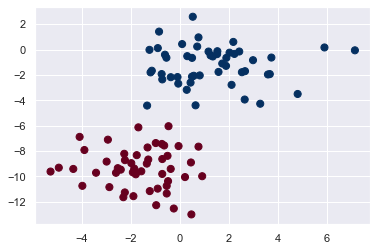

In [9]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

One extremely fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and standard deviation of the points within each label, which is all you need to define such a distribution. The result of this naive Gaussian assumption is shown in the following figure:

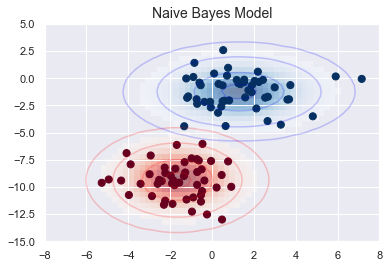

In [11]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

fig.savefig('gaussian-NB.png')

The ellipses here represent the Gaussian generative model for each label, with larger probability toward the center of the ellipses. With this generative model in place for each class, we have a simple recipe to compute the likelihood $P({\rm features}~|~L_1)$ for any data point, and thus we can quickly compute the posterior ratio and determine which label is the most probable for a given point.

This procedure is implemented in Scikit-Learn's `sklearn.naive_bayes.GaussianNB` estimator:

In [12]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Now let's generate some new data and predict the label:

In [13]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Now we can plot this new data to get an idea of where the decision boundary is:

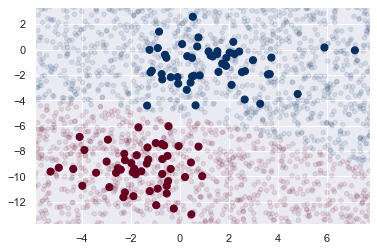

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

We see a slightly curved boundary in the classifications—in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute using the `predict_proba` method:

In [15]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

The columns give the posterior probabilities of the first and second label, respectively. If you are looking for estimates of uncertainty in your classification, Bayesian approaches like this can be a useful approach.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results. Still, in many cases—especially as the number of features becomes large—this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

# Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label. Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represent counts or count rates.

The idea is precisely the same as before, except that instead of modeling the data distribution with the best-fit Gaussian, we model the data distribuiton with a best-fit multinomial distribution.

## Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified. We discussed the extraction of such features from text in Feature Engineering; here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [17]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [18]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [21]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorizer (discussed in Feature Engineering), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [23]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator. For example, here is the confusion matrix between the true and predicted labels for the test data:

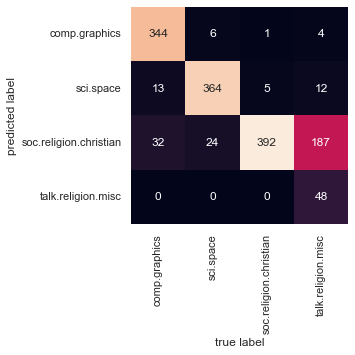

In [24]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity. This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for any string, using the `predict()` method of this pipeline. Here's a quick utility function that will return the prediction for a single string:

In [25]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [26]:
predict_category('sending a payload to the ISS')

'sci.space'

In [27]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [28]:
predict_category('determining the screen resolution')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking. Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

# When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model. That said, they have several advantages:

    They are extremely fast for both training and prediction
    They provide straightforward probabilistic prediction
    They are often very easily interpretable
    They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

    When the naive assumptions actually match the data (very rare in practice)
    For very well-separated categories, when model complexity is less important
    For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in every single dimension to be close overall). This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information. For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

# Topic: In Depth: Linear Regression

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

We will start with the most familiar linear regression, a straight-line fit to data. A straight-line fit is a model of the form

                    y=ax+b

where a is commonly known as the slope, and b is commonly known as the intercept.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

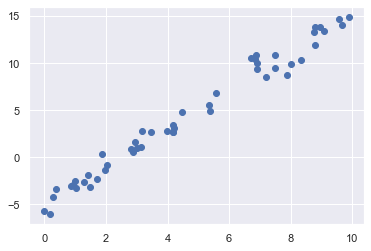

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line:

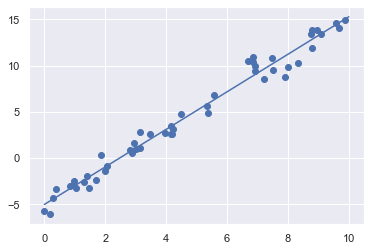

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are `coef_` and `intercept_`:

In [6]:
# y = ax+b
print("Model slope (a):    ", model.coef_[0])
print("Model intercept (b):", model.intercept_)

Model slope (a):     2.027208810360695
Model intercept (b): -4.998577085553202


We see that the results are very close to the inputs, as we might hope.

The `LinearRegression` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form

                                    y=a0+a1x1+a2x2+⋯

where there are multiple x values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [7]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000122
[ 1.5 -2.   1. ]


Here the y data is constructed from three random x values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single `LinearRegression` estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

# Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions. We have seen one version of this before, in the `PolynomialRegression` pipeline used in Hyperparameters and Model Validation and Feature Engineering. The idea is to take our multidimensional linear model:

                        y=a0+a1x1+a2x2+a3x3+⋯

and build the x1,x2,x3, and so on, from our single-dimensional input x. That is, we let xn=fn(x), where fn() is some function that transforms our data.

For example, if fn(x)=x^n, our model becomes a polynomial regression:

                        y=a0+a1x+a2x^2+a3x^3+⋯

Notice that this is still a linear model—the linearity refers to the fact that the coefficients a_n never multiply or divide each other. What we have effectively done is taken our one-dimensional x values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between x and y.

## Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the `PolynomialFeatures` transformer:

In [8]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value. This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in Feature Engineering, the cleanest way to accomplish this is to use a pipeline. Let's make a 7th-degree polynomial model in this way:

As we saw in Feature Engineering, the cleanest way to accomplish this is to use a pipeline. Let's make a 7th-degree polynomial model in this way:

In [9]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between x and y. For example, here is a sine wave with noise:

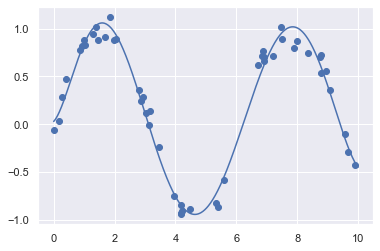

In [11]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

## Gaussian basis functions

Of course, other basis functions are possible. For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. The result might look something like the following figure:

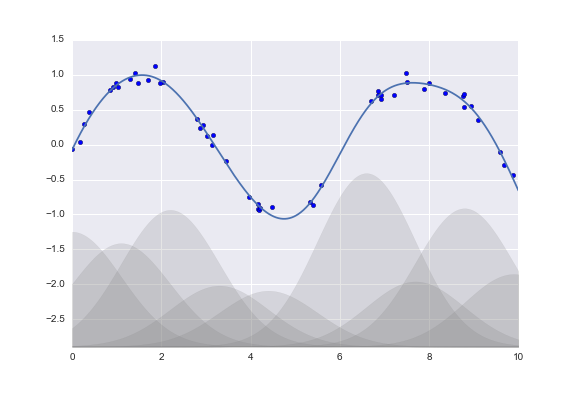

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them, as shown here and illustrated in the following figure (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

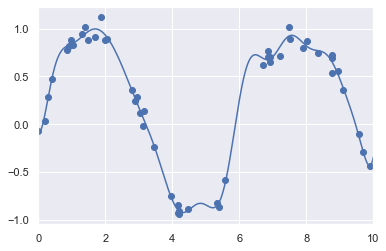

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

# Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting (refer back to Hyperparameters and Model Validation for a discussion of this). For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

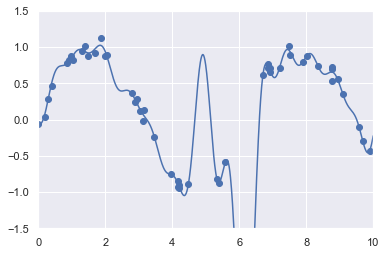

In [13]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

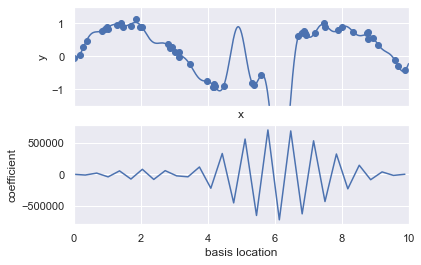

In [14]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms.

## Ridge regression (L2 Regularization)

Perhaps the most common form of regularization is known as ridge regression or L2 regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be

$P = \alpha\sum_{n=1}^N \theta_n^2$

where α is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator:

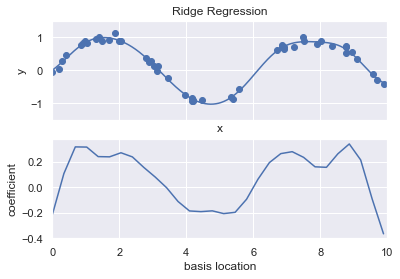

In [16]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The α parameter is essentially a knob controlling the complexity of the resulting model. In the limit α→0, we recover the standard linear regression result; in the limit α→∞, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

## Lasso regression (L1 regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$P = \alpha\sum_{n=1}^N |\theta_n|$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870486668, tolerance: 0.002065280097246271
  model = cd_fast.enet_coordinate_descent(


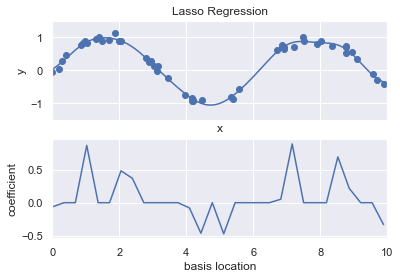

In [19]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the α parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation (refer back to Hyperparameters and Model Validation for a discussion of this).

# Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors. We have seen this data already in Working With Time Series.

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily weather station data (I used station ID USW00024233) and we can easily use Pandas to join the two data sources. We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning. As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [25]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [26]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [27]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [28]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8.0, 17.0)

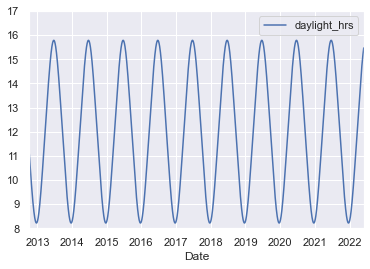

In [30]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [31]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [32]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [34]:
daily.head()

Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs  \
Date                                                                            
2012-10-03  14084.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359   
2012-10-04  13900.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142   
2012-10-05  12592.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038   
2012-10-06   8024.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056   
2012-10-07   8568.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208   

            PRCP  Temp (C)  dry day    annual  
Date                                           
2012-10-03   0.0     13.35      1.0  0.000000  
2012-10-04   0.0     13.60      1.0  0.002740  
2012-10-05   0.0     15.30      1.0  0.005479  
2012-10-06   0.0     15.85      1.0  0.008219  
2012-10-07   0.0     15.85      1.0  0.010959

With this in place, we can choose the columns to use, and fit a linear regression model to our data. We will set `fit_intercept = False', because the daily flags essentially operate as their own day-specific intercepts:

In [35]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

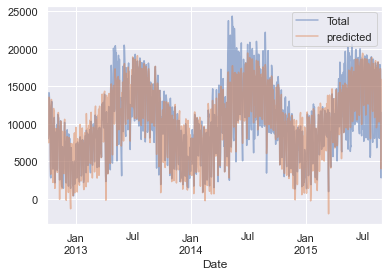

In [36]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time. Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures). Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [37]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             2019.531023
Tue             2440.935744
Wed             2370.694566
Thu             1929.432461
Fri              711.921382
Sat            -4413.206842
Sun            -4534.268983
holiday        -4749.605523
daylight_hrs     515.406045
PRCP           -2659.339527
dry day         2190.794369
Temp (C)         260.651164
annual           107.770852
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [38]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [39]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           2020.0  345.0
Tue           2441.0  333.0
Wed           2371.0  331.0
Thu           1929.0  341.0
Fri            712.0  324.0
Sat          -4413.0  318.0
Sun          -4534.0  332.0
holiday      -4750.0  653.0
daylight_hrs   515.0   36.0
PRCP         -2659.0  249.0
dry day       2191.0  133.0
Temp (C)       261.0   14.0
annual         108.0   71.0


We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. We see that for each additional hour of daylight, 515 ± 36 more people choose to ride; a temperature increase of one degree Celsius encourages 261 ± 14 people to grab their bicycle; a dry day means an average of 2191 ± 133 more riders, and each inch of precipitation means 2659 ± 249 more people leave their bike at home. Once all these effects are accounted for, we see a modest increase of 108 ± 71 new daily riders each year.

Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

# Topic: In-Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# Motivating Support Vector Machines

As part of our disussion of Bayesian classification (see In Depth: Naive Bayes Classification), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points. That was an example of generative classification; here we will consider instead discriminative classification: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

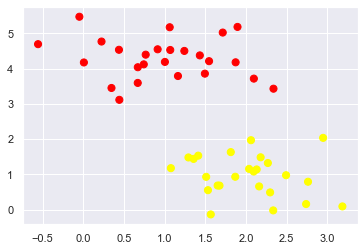

In [10]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

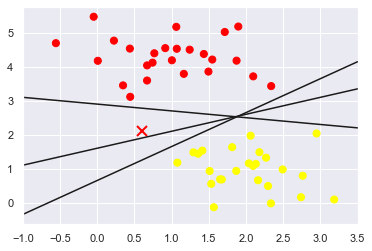

In [11]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

# Support Vector Machines: Maximizing the Margin

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

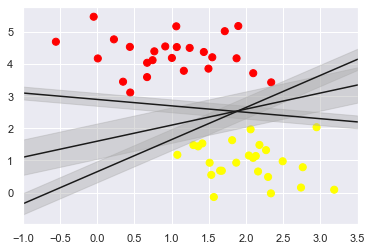

In [12]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

## Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the `C` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [13]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [14]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

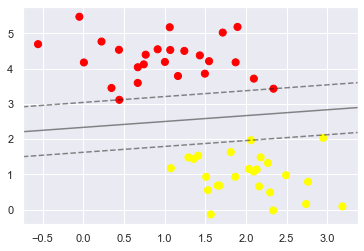

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the `support_vectors_` attribute of the classifier:

In [16]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

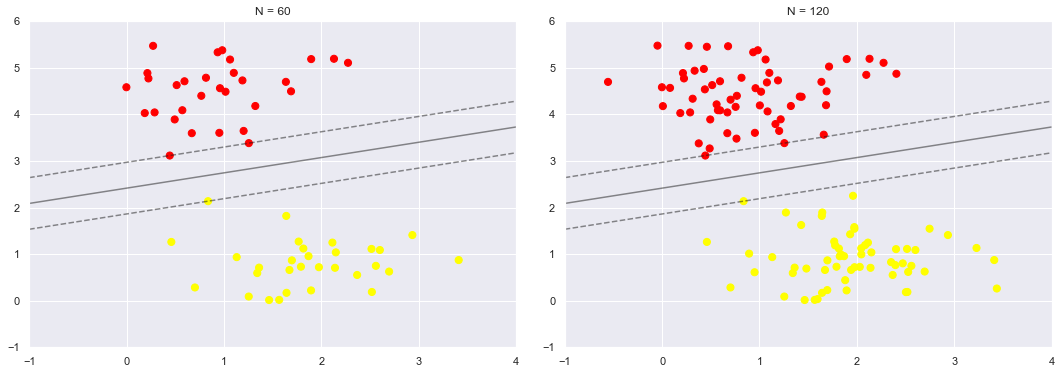

In [18]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [19]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with kernels. We have seen a version of kernels before, in the basis function regressions of In Depth: Linear Regression. There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let's look at some data that is not linearly separable:

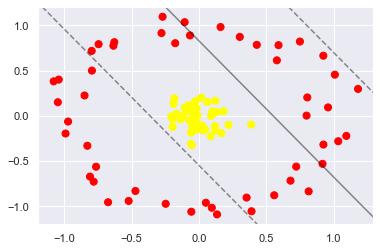

In [21]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. But we can draw a lesson from the basis function regressions in In Depth: Linear Regression, and think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump:

In [22]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [23]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting N points into N dimensions—is that it might become very computationally intensive as N grows large. However, because of a neat little procedure known as the kernel trick, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full N-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the `kernel` model hyperparameter:

In [24]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

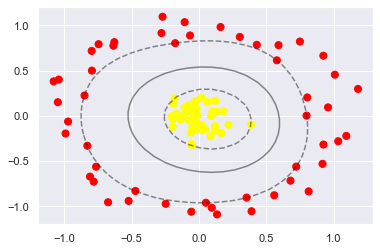

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

## Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap? For example, you may have data like this:

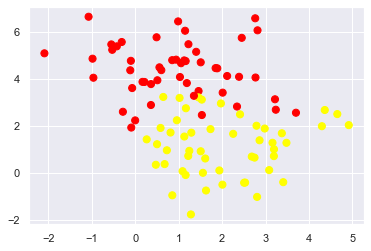

In [26]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as C. For very large C, the margin is hard, and points cannot lie in it. For smaller C, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing C parameter affects the final fit, via the softening of the margin:

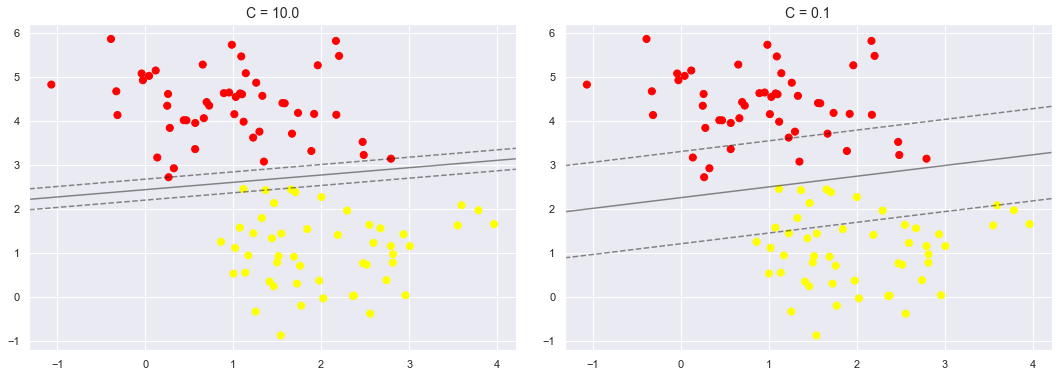

In [27]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the C parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to Hyperparameters and Model Validation).

# Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem. We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn:

In [28]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

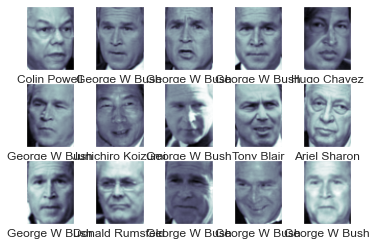

In [31]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see In Depth: Principal Component Analysis) to extract 150 fundamental components to feed into our support vector machine classifier. We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [33]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [35]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters. Here we will adjust `C` (which controls the margin hardness) and `gamma` (which controls the size of the radial basis function kernel), and determine the best model:

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 37.2 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [38]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

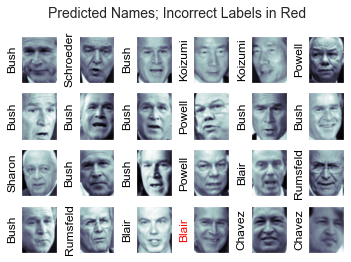

In [39]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s face in the bottom row was mislabeled as Blair). We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [40]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

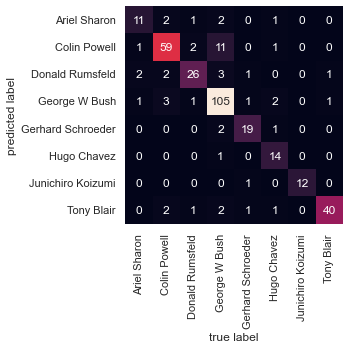

In [41]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation. For this kind of application, one good option is to make use of OpenCV, which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

# Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines. These methods are a powerful classification method for a number of reasons:

    Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
    Once the model is trained, the prediction phase is very fast.
    Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
    Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

    The scaling with the number of samples N is O[N3] at worst, or O[N2] for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
    The results are strongly dependent on a suitable choice for the softening parameter C. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
    The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs. Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

# Topic: In-Depth: Decision Trees and Random Forests

Previously we have looked in depth at a simple generative classifier (naive Bayes; see In Depth: Naive Bayes Classification) and a powerful discriminative classifier (support vector machines; see In-Depth: Support Vector Machines). Here we'll take a look at motivating another powerful algorithm—a non-parametric algorithm called random forests. Random forests are an example of an ensemble method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting! We will see examples of this in the following sections. We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Motivating Random Forests: Decision Trees

Random forests are an example of an ensemble learner built on decision trees. For this reason we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. For example, if you wanted to build a decision tree to classify an animal you come across while on a hike, you might construct the one shown here:

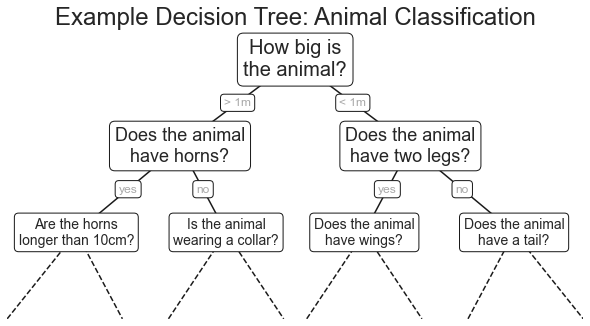

In [3]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

fig.savefig('05.08-decision-tree.png')

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The trick, of course, comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features. Let's now look at an example of this.

## Helper Code

The following will create a module `helpers_05_08.py` which contains some tools used in In-Depth: Decision Trees and Random Forests.

In [6]:
%%file helpers_05_08.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

Writing helpers_05_08.py


## Creating a decision tree

Consider the following two-dimensional data, which has one of four class labels:

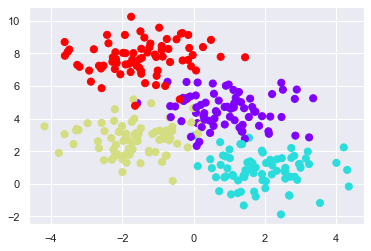

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. This figure presents a visualization of the first four levels of a decision tree classifier for this data:

C:\Users\DELL\Desktop\Data Science Book\Python Data Science Handbook ( PDFDrive )\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
C:\Users\DELL\Desktop\Data Science Book\Python Data Science Handbook ( PDFDrive )\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
C:\Users\DELL\Desktop\Data Science Book\Python Data Science Handbook ( PDFDrive )\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
C:\Users\DELL\Desktop\Data Science Book\Python Data Science Handbook ( PDFDrive )\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


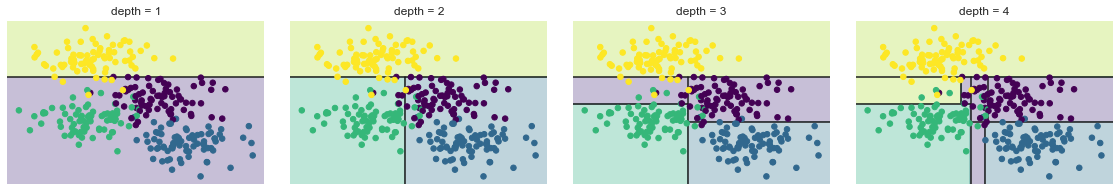

In [7]:
from helpers_05_08 import visualize_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

        
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

fig.savefig('05.08-decision-tree-levels.png')

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch. Except for nodes that contain all of one color, at each level every region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the `DecisionTreeClassifier` estimator:

In [8]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a quick utility function to help us visualize the output of the classifier:

In [9]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like:

C:\Users\DELL\AppData\Local\Temp/ipykernel_4672/520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


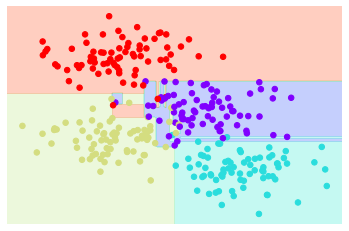

In [10]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [11]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions. It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

## Decision trees and over-fitting

Such over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from. Another way to see this over-fitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data:

C:\Users\DELL\Desktop\Data Science Book\Python Data Science Handbook ( PDFDrive )\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,
C:\Users\DELL\Desktop\Data Science Book\Python Data Science Handbook ( PDFDrive )\helpers_05_08.py:31: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


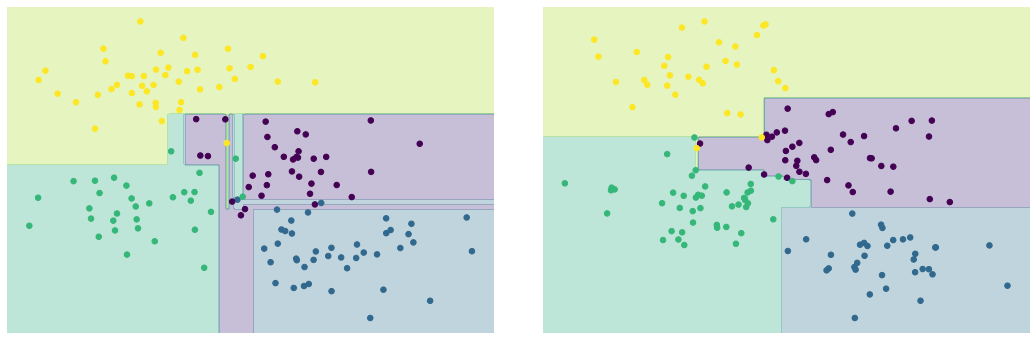

In [13]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

fig.savefig('05.08-decision-tree-overfitting.png')

It is clear that in some places, the two trees produce consistent results (e.g., in the four corners), while in other places, the two trees give very different classifications (e.g., in the regions between any two clusters). The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from both of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

In [15]:
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

# Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called bagging. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a random forest.

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here:

C:\Users\DELL\AppData\Local\Temp/ipykernel_4672/520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


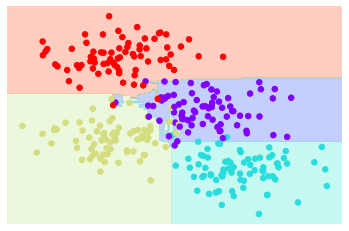

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. For example, when determining which feature to split on, the randomized tree might select from among the top several features. You can read more technical details about these randomization strategies in the Scikit-Learn documentation and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

C:\Users\DELL\AppData\Local\Temp/ipykernel_4672/520376207.py:20: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


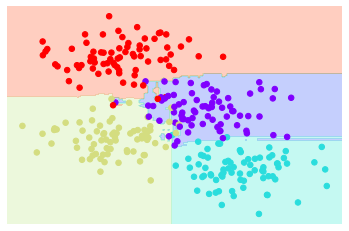

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

# Random Forest Regression

In the previous section we considered random forests within the context of classification. Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

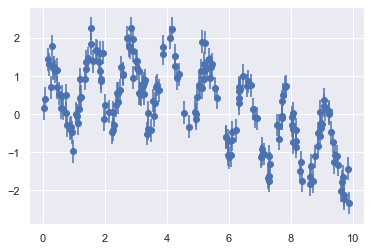

In [19]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

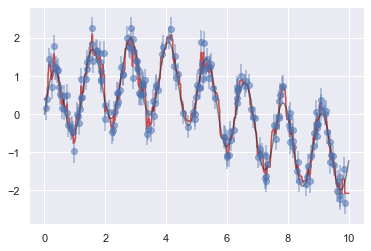

In [20]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

# Example: Random Forest for Classifying Digits

Earlier we took a quick look at the hand-written digits data (see Introducing Scikit-Learn). Let's use that again here to see how the random forest classifier can be used in this context.

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

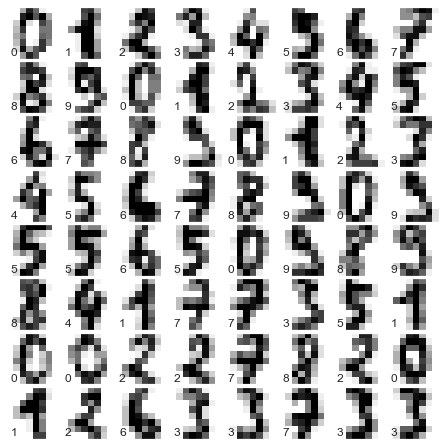

In [22]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [24]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:

In [25]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

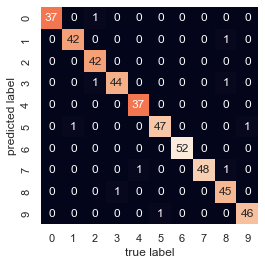

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a very accurate classification of the digits data.

# Summary of Random Forests

This section contained a brief introduction to the concept of ensemble estimators, and in particular the random forest – an ensemble of randomized decision trees. Random forests are a powerful method with several advantages:

    Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
    
    The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).
    
    The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.

# Topic: In Depth: Principal Component Analysis

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data. Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA). PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more. After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

We begin with the standard imports:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data, which we saw briefly in Introducing Scikit-Learn. Its behavior is easiest to visualize by looking at a two-dimensional dataset. Consider the following 200 points:

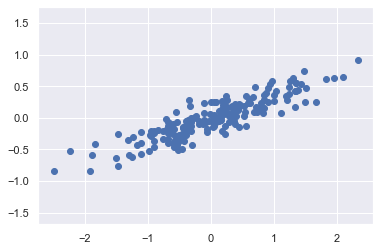

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. This is reminiscent of the linear regression data we explored in In Depth: Linear Regression, but the problem setting here is slightly different: rather than attempting to predict the y values from the x values, the unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset. Using Scikit-Learn's `PCA` estimator, we can compute this as follows:

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [5]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [6]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:

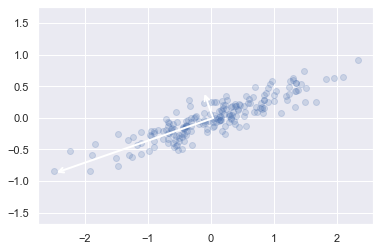

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the "principal components" of the data.

If we plot these principal components beside the original data, we see the plots shown here:

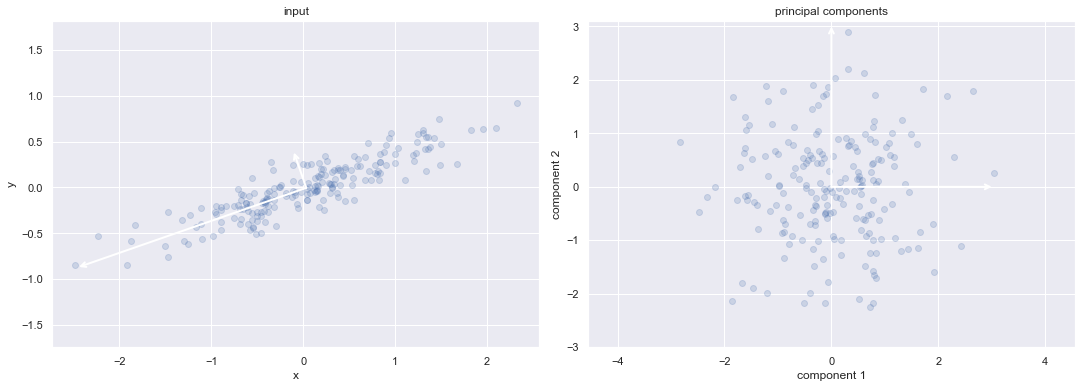

In [8]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

fig.savefig('05.09-PCA-rotation.png')

This transformation from data axes to principal axes is an affine transformation, which basically means it is composed of a translation, rotation, and uniform scaling.

While this algorithm to find principal components may seem like just a mathematical curiosity, it turns out to have very far-reaching applications in the world of machine learning and data exploration.

## PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [9]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension. To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

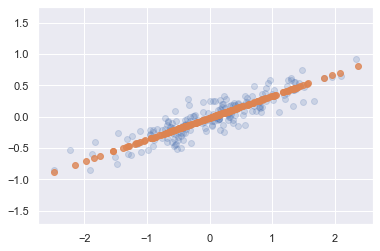

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

## PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data. To see this, let's take a quick look at the application of PCA to the digits data we saw in In-Depth: Decision Trees and Random Forests.

We start by loading the data:

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional. To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [13]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

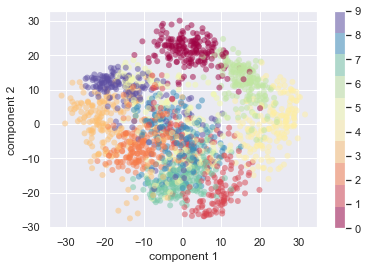

In [15]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

## What do the components mean? --> In the book

## Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:

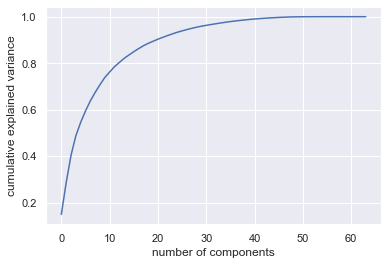

In [16]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components. For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

# PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data. The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data. First we will plot several of the input noise-free data:

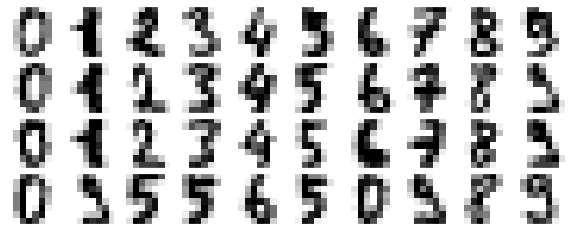

In [17]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

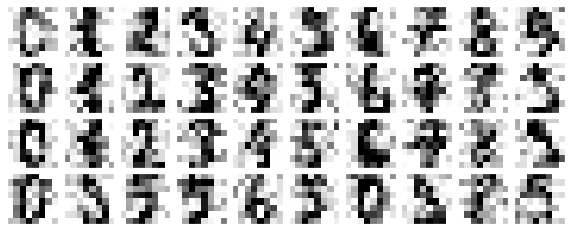

In [18]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels. Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

In [19]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

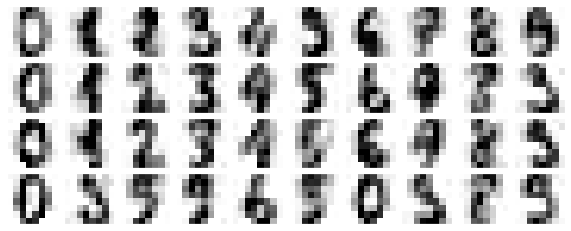

In [20]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

# Example: Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine (see In-Depth: Support Vector Machines). Here we will take a look back and explore a bit more of what went into that. Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's take a look at the principal axes that span this dataset. Because this is a large dataset, we will use `RandomizedPCA`—it contains a randomized method to approximate the first N principal components much more quickly than the standard `PCA` estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000). We will take a look at the first 150 components:

In [24]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

PCA(n_components=150)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors," so these types of images are often called "eigenfaces"). As you can see in this figure, they are as creepy as they sound:

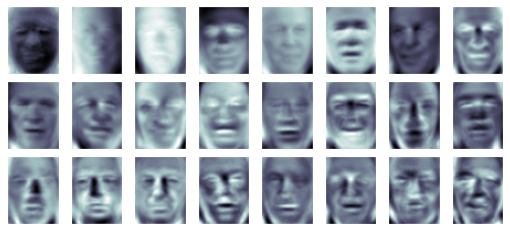

In [25]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips. Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

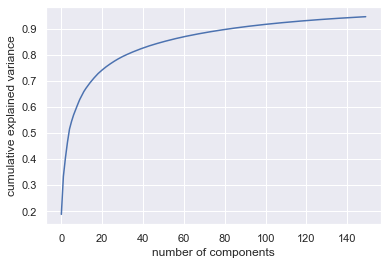

In [26]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance. That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data. To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [27]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

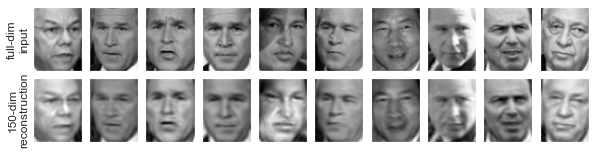

In [28]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features. This visualization makes clear why the PCA feature selection used in In-Depth: Support Vector Machines was so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image. What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

# Principal Component Analysis Summary

In this section we have discussed the use of principal component analysis for dimensionality reduction, for visualization of high-dimensional data, for noise filtering, and for feature selection within high-dimensional data. Because of the versatility and interpretability of PCA, it has been shown to be effective in a wide variety of contexts and disciplines. Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio). Certainly PCA is not useful for every high-dimensional dataset, but it offers a straightforward and efficient path to gaining insight into high-dimensional data.

PCA's main weakness is that it tends to be highly affected by outliers in the data. For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components. Scikit-Learn contains a couple interesting variants on PCA, including `RandomizedPCA` and `SparsePCA`, both also in the `sklearn.decomposition` submodule. `RandomizedPCA`, which we saw earlier, uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data, while `SparsePCA` introduces a regularization term (see In Depth: Linear Regression) that serves to enforce sparsity of the components.

In the following sections, we will look at other unsupervised learning methods that build on some of the ideas of PCA.

# Topic: In-Depth: Manifold Learning

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points. While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are nonlinear relationships within the data; we will see some examples of these below.

To address this deficiency, we can turn to a class of methods known as manifold learning—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces. When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions. In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear. Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin with the standard imports:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Manifold Learning: "HELLO"

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold. Here is a function that will create data in the shape of the word "HELLO":

In [4]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

Let's call the function and visualize the resulting data:

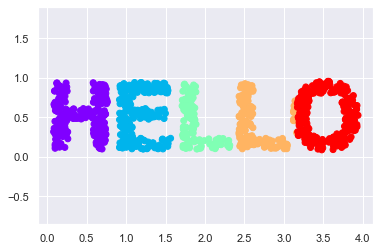

In [5]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO". This data form will help us to see visually what these algorithms are doing.

# Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of x and y values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent. For example, if we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same:

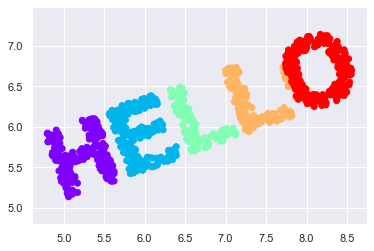

In [6]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

This tells us that the x and y values are not necessarily fundamental to the relationships in the data. What is fundamental, in this case, is the distance between each point and the other points in the dataset. A common way to represent this is to use a distance matrix: for N points, we construct an N×N array such that entry (i,j) contains the distance between point i and point j. Let's use Scikit-Learn's efficient `pairwise_distances` function to do this for our original data:

In [7]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

As promised, for our N=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

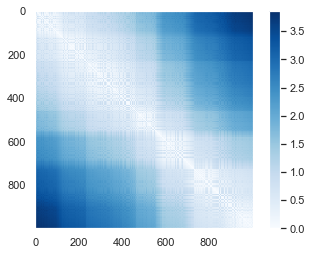

In [8]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [9]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive. In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into x and y coordinates is rather difficult. This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a D-dimensional coordinate representation of the data. Let's see how it works for our distance matrix, using the `precomputed` dissimilarity to specify that we are passing a distance matrix:

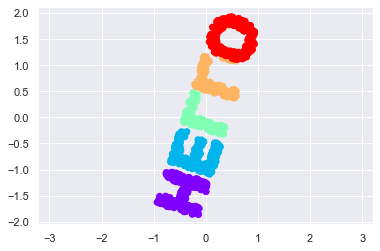

In [10]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using only the N×N distance matrix describing the relationship between the data points.

# MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in any dimension. So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [11]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

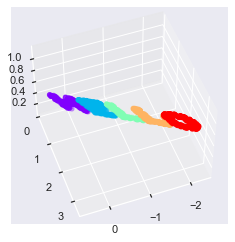

In [12]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

We can now ask the `MDS` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix. The result recovers a representation of the original data:

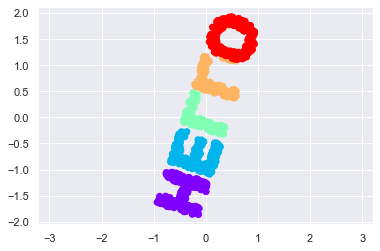

In [13]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data. In the case of MDS, the quantity preserved is the distance between every pair of points.

# Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered linear embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations. Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [14]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

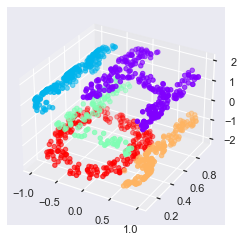

In [15]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

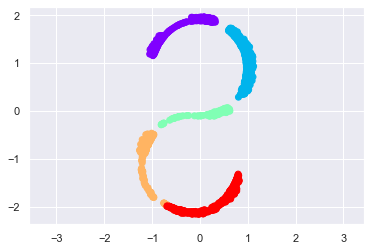

In [16]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

The best two-dimensional linear embeding does not unwrap the S-curve, but instead throws out the original y-axis.

# Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding. But what if we instead modified the algorithm such that it only preserves distances between nearby points? The resulting embedding would be closer to what we want.

Visually, we can think of it as illustrated in this figure:

In [17]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as png
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

In [18]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

X = make_hello(1000)
XS = make_hello_s_curve(X)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))

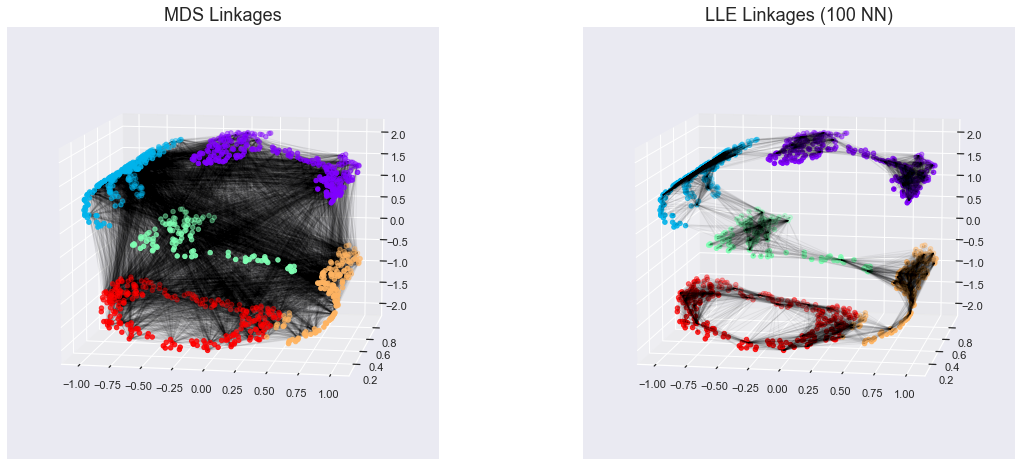

In [19]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

fig.savefig('05.10-LLE-vs-MDS.png')

Here each faint line represents a distance that should be preserved in the embedding. On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset. On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving all distances, it instead tries to preserve only the distances between neighboring points: in this case, the nearest 100 neighbors of each point.

Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points. For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same. This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

LLE comes in a number of flavors; here we will use the modified LLE algorithm to recover the embedded two-dimensional manifold. In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

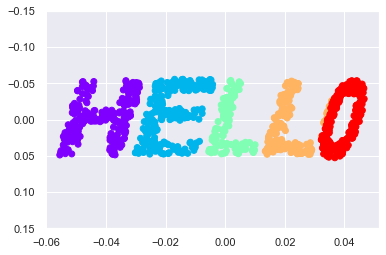

In [20]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

# Some Thoughts on Manifold Methods

Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

    In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
    
    In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
    
    The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
    
    In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.
    
    In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
    
    In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a nice discussion and comparison of them. Based on my own experience, I would give the following recommendations:

    For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially modified LLE), perform very well. This is implemented in sklearn.manifold.LocallyLinearEmbedding.
    
    For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap
    
    For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE.

If you're interested in getting a feel for how these work, I'd suggest running each of the methods on the data in this section.

# Example: Isomap on Faces

One place manifold learning is often used is in understanding the relationship between high-dimensional data points. A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Here let's apply Isomap on some faces data. We will use the Labeled Faces in the Wild dataset, which we previously saw in In-Depth: Support Vector Machines and In Depth: Principal Component Analysis. Running this command will download the data and cache it in your home directory for later use:

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels. In other words, the images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:

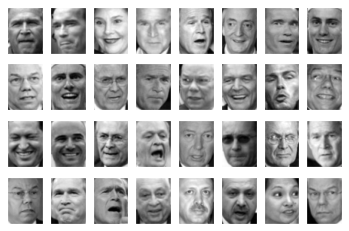

In [22]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images. One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

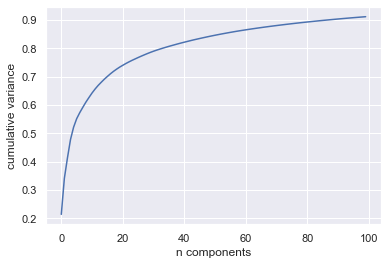

In [24]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful. We can compute an Isomap embedding on these faces using the same pattern shown before:

In [25]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images. To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

In [26]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Calling this function now, we see the result:

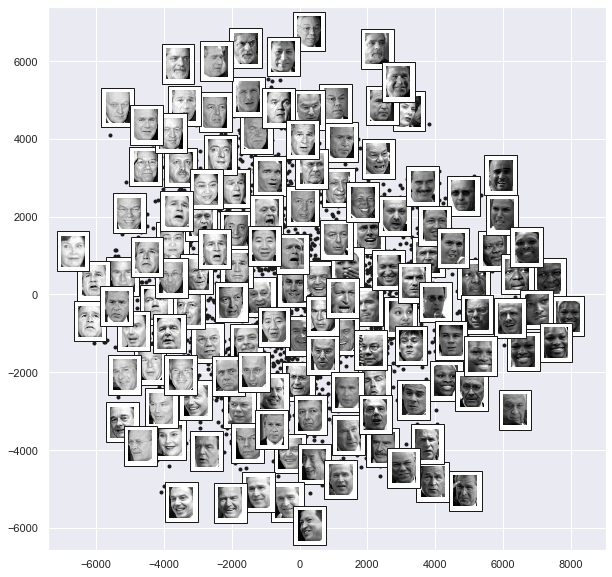

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top. This gives us a nice visual indication of some of the fundamental features in our data.

We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) as we did in In-Depth: Support Vector Machines.

# Example: Visualizing Structure in Digits

As another example of using manifold learning for visualization, let's take a look at the MNIST handwritten digits set. This data is similar to the digits we saw in In-Depth: Decision Trees and Random Forests, but with many more pixels per image. It can be downloaded from http://mldata.org/ with the Scikit-Learn utility:

In [32]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets' (C:\Users\DELL\anaconda3\lib\site-packages\sklearn\datasets\__init__.py)

This consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28). As before, we can take a look at the first few images:

NameError: name 'mnist' is not defined

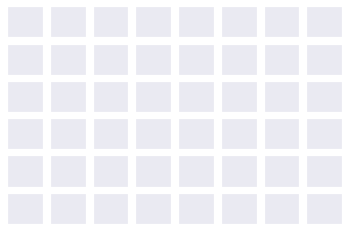

In [33]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

This gives us an idea of the variety of handwriting styles in the dataset.

Let's compute a manifold learning projection across the data. For speed here, we'll only use 1/30 of the data, which is about ~2000 points (because of the relatively poor scaling of manifold learning, I find that a few thousand samples is a good number to start with for relatively quick exploration before moving to a full calculation):

In [ ]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded. We can gain more insight by looking at just a single number at a time:

In [ ]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

The result gives you an idea of the variety of forms that the number "1" can take within the dataset. The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit. As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset. The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

Now, this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.

# Topic: In Depth: k-Means Clustering

In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction. Here we will move on to another class of unsupervised machine learning models: clustering algorithms. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as k-means clustering, which is implemented in `sklearn.cluster.KMeans`.

We begin with the standard imports:

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

# Introducing k-Means

The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

    The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
    
    Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the k-means model. We will soon dive into exactly how the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the k-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

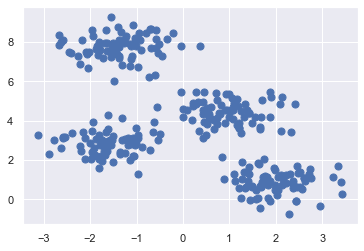

In [36]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels. We will also plot the cluster centers as determined by the k-means estimator:

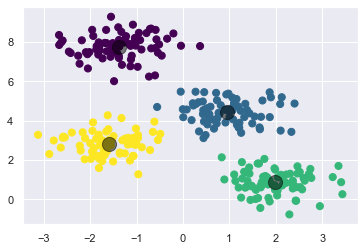

In [38]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye. But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly. Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to k-means involves an intuitive iterative approach known as expectation–maximization.

# k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here. In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers

2. Repeat until converged

    1. E-Step: assign points to the nearest cluster center
    
    2. M-Step: set the cluster centers to the mean
    
Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to. The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure. For the particular initialization shown here, the clusters converge in just three iterations. For an interactive version of this figure, refer to the code in the Appendix.

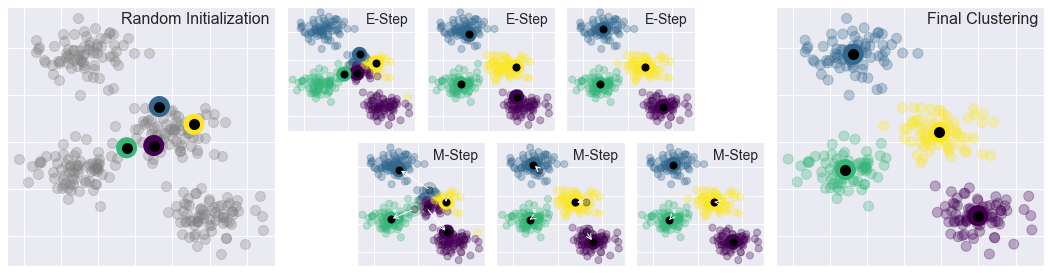

In [40]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, cmap='viridis',
               s=50 * factor, alpha=0.3)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


fig.savefig('05.11-expectation-maximization.png')

The k-Means algorithm is simple enough that we can write it in a few lines of code. The following is a very basic implementation:

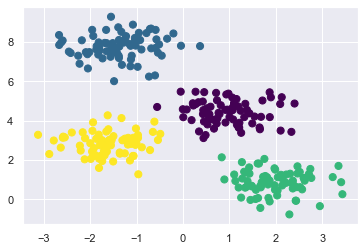

In [43]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');


Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

## Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

### The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

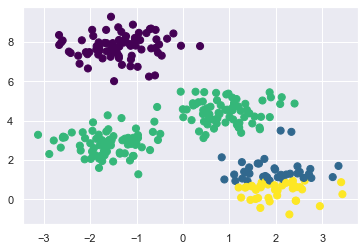

In [44]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init` parameter, which defaults to 10).

### The number of clusters must be selected beforehand

Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data. For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

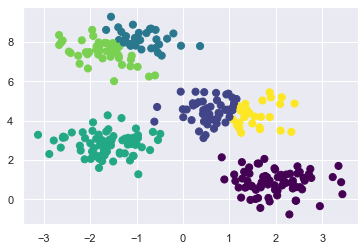

In [45]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called silhouette analysis.

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see In Depth: Gaussian Mixture Models) or which can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the `sklearn.cluster` submodule)

### k-means is limited to linear cluster boundaries

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries. Consider the following data, along with the cluster labels found by the typical k-means approach:

In [47]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

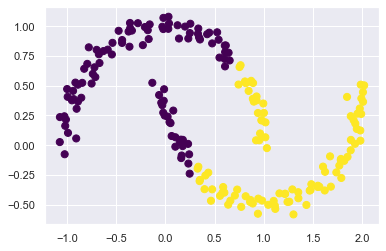

In [48]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation is reminiscent of the discussion in In-Depth: Support Vector Machines, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible. We might imagine using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


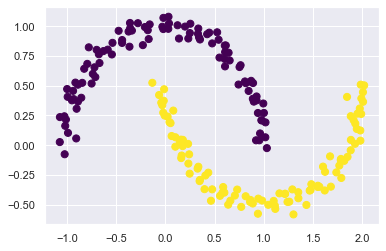

In [49]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

### k-means can be slow for large numbers of samples

Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

# Examples

Being careful about these limitations of the algorithm, we can use k-means to our advantage in a wide variety of situations. We'll now take a look at a couple examples.

## Example 1: k-means on digits

To start, let's take a look at applying k-means on the same simple digits data that we saw in In-Depth: Decision Trees and Random Forests and In Depth: Principal Component Analysis. Here we will attempt to use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

We will start by loading the digits and then finding the `KMeans` clusters. Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [50]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [51]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's see what these cluster centers look like:

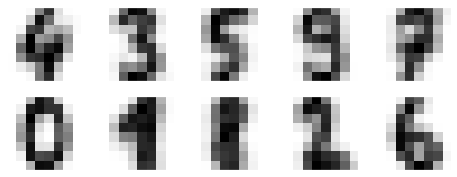

In [52]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, `KMeans` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:

In [53]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let's check the confusion matrix for this:

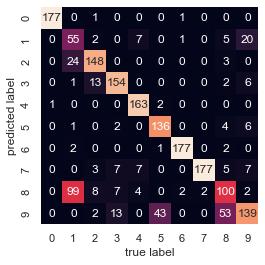

In [55]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels!

Just for fun, let's try to push this even farther. We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in In-Depth: Manifold Learning) to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [56]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9348914858096828

That's nearly 92% classification accuracy without using the labels. This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

## Example 2: k-means for color compression

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn `datasets` module (for this to work, you'll have to have the `pillow` Python package installed).

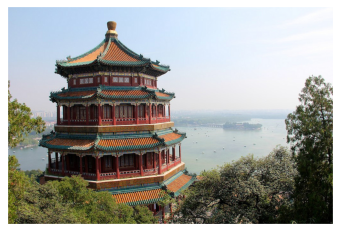

In [57]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size (`height`,`width`, `RGB`), containing red/blue/green contributions as integers from 0 to 255:

In [58]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to [`n_samples x n_features`], and rescale the colors so that they lie between 0 and 1:

In [59]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [60]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

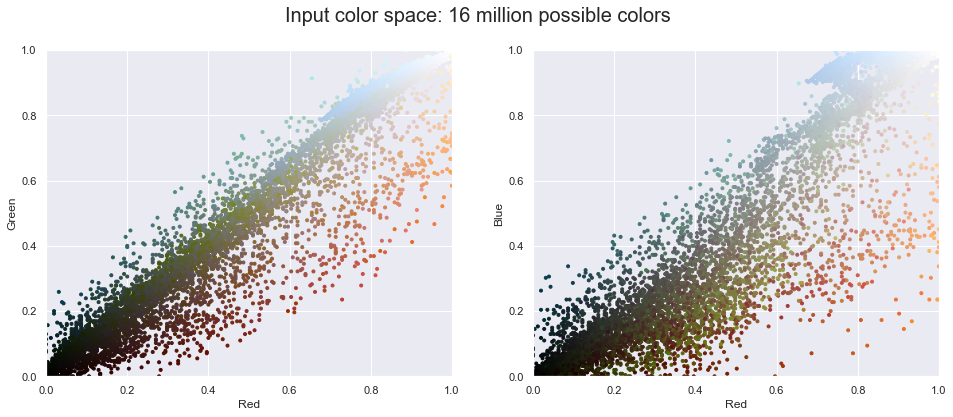

In [61]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a k-means clustering across the pixel space. Because we are dealing with a very large dataset, we will use the mini batch k-means, which operates on subsets of the data to compute the result much more quickly than the standard k-means algorithm:

In [65]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

AttributeError: 'NoneType' object has no attribute 'split'

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

In [66]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

NameError: name 'new_colors' is not defined

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better way to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.

# Topic: In Depth: Gaussian Mixture Models

The k-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of k-means and think about how we might improve the cluster model. As we saw in the previous section, given simple, well-separated data, k-means finds suitable clustering results.

For example, if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [4]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

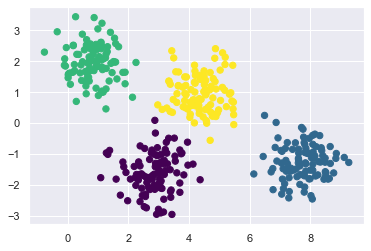

In [5]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

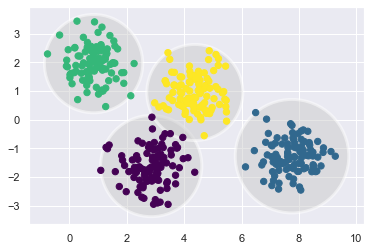

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

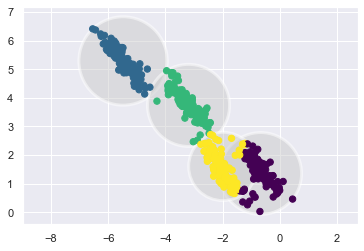

In [8]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot. One might imagine addressing this particular situation by preprocessing the data with PCA (see In Depth: Principal Component Analysis), but in practice there is no guarantee that such a global operation will circularize the individual data.

These two disadvantages of k-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the k-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters. It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

# Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

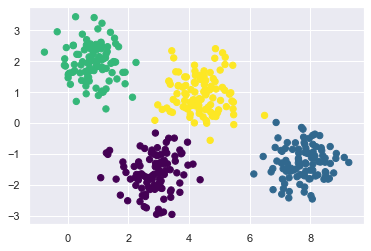

In [10]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the `predict_proba` method. This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [11]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

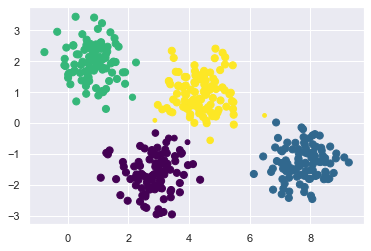

In [12]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to k-means: it uses an expectation–maximization approach which qualitatively does the following:

    Choose starting guesses for the location and shape

    Repeat until converged:

        E-step: for each point, find weights encoding the probability of membership in each cluster

        M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [13]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

AttributeError: 'GaussianMixture' object has no attribute 'covars_'

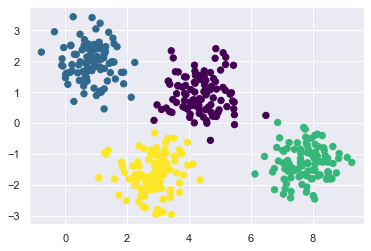

In [15]:
gmm = mixture.GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)